In [1]:
import re
import os
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K

In [2]:
optimizer = RMSprop(learning_rate=0.00005)

In [4]:
smooth = 1.

In [5]:
def discriminator_loss(y_true,y_pred):
    BATCH_SIZE=30
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.concatenate([K.ones_like(K.flatten(y_pred[:BATCH_SIZE])),K.zeros_like(K.flatten(y_pred[:BATCH_SIZE])) ]) ), axis=-1)


In [6]:
def discriminator_on_generator_loss(y_true,y_pred):
    BATCH_SIZE=30
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.ones_like(K.flatten(y_pred))), axis=-1)

In [7]:
def generator_l1_loss(y_true,y_pred):
    BATCH_SIZE=30
    return K.mean(K.abs(K.flatten(y_pred) - K.flatten(y_true)), axis=-1)

In [8]:
def least_absolute_error(y_true, y_pred):
    return (K.abs(y_pred - y_true))

In [9]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [10]:
def mean_squared_error(y_true, y_pred):
    return 10*K.mean(K.square(y_pred - y_true), axis=-1)

In [11]:
image_path = 'Dataset/photos'
img_array = []

In [12]:
sketch_path = 'Dataset/sketches'
sketch_array = []

In [13]:
SIZE = 256

In [14]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [15]:
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))

In [16]:
image_file = sorted_alphanumeric(os.listdir(image_path))

In [17]:
for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype('float32') / 255.0
    img_array.append(img_to_array(image))
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
    img3 = cv2.flip(image,-1)
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5)) 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:06<00:00, 30.04it/s]


In [18]:
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype('float32') / 255.0
    sketch_array.append(img_to_array(image))
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
    img3 = cv2.flip(image,-1)
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:04<00:00, 42.73it/s]


In [19]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


In [20]:
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
    plt.subplot(1,2,2)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    
   
    plt.show()

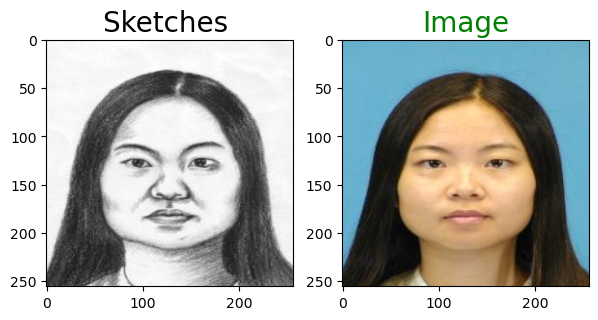

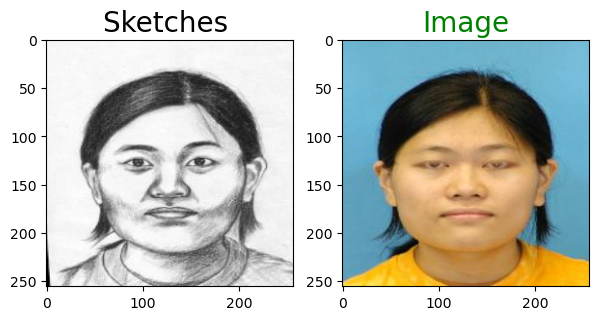

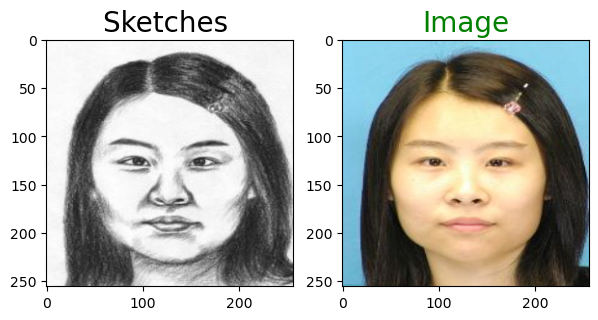

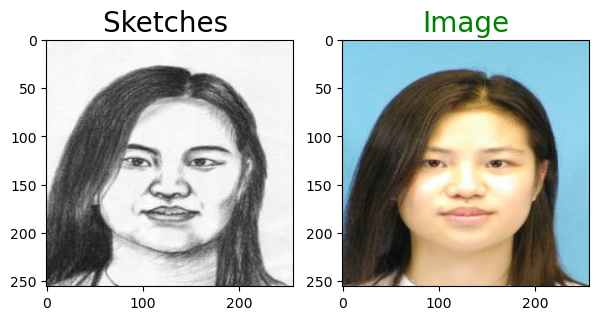

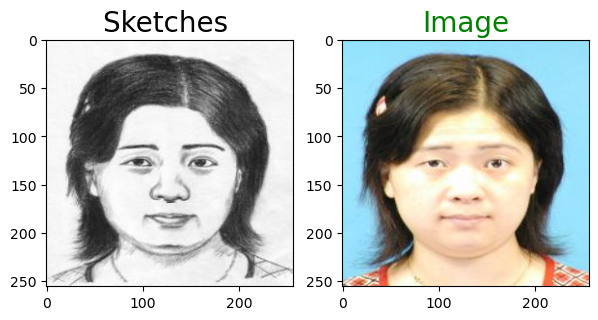

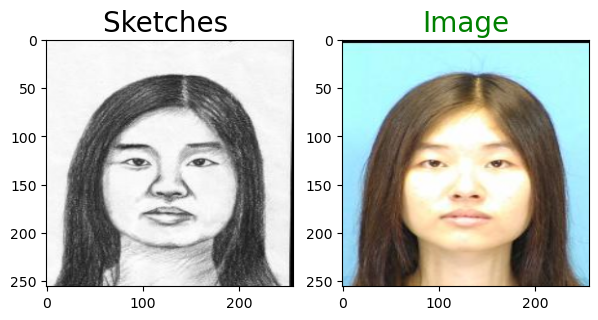

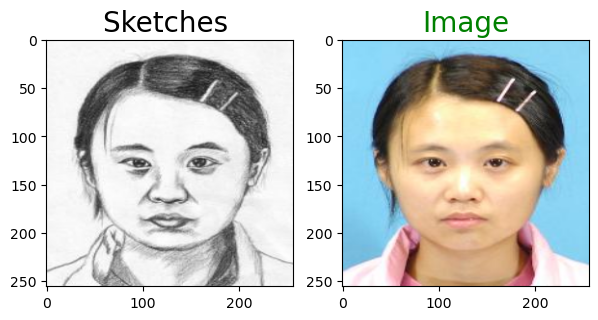

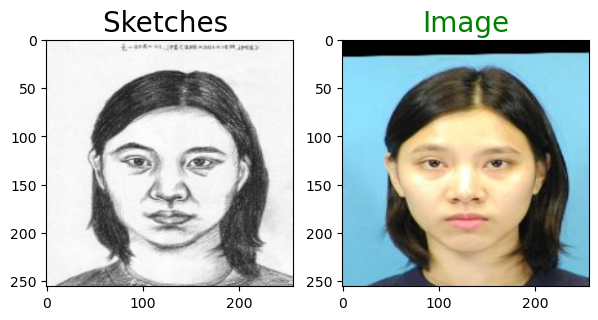

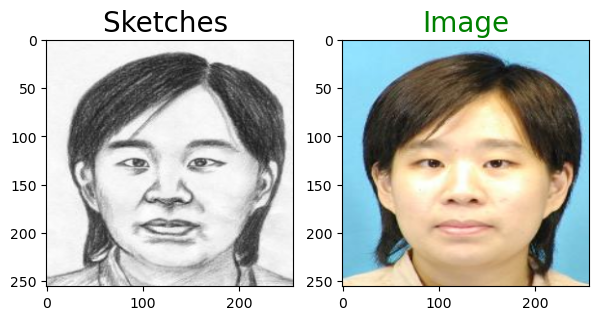

In [21]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])


In [22]:
train_sketch_image = sketch_array[:1000]
train_image = img_array[:1000]

In [23]:
test_sketch_image = sketch_array[1000:]
test_image = img_array[1000:]

In [24]:
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))

In [25]:
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))

In [26]:
print('Train color image shape:',train_image.shape)

Train color image shape: (1000, 256, 256, 3)


In [27]:
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))

In [28]:
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))

In [29]:
print('Test color image shape',test_image.shape)

Test color image shape (504, 256, 256, 3)


In [30]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = Sequential()
    downsample.add(Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample

In [31]:
def upsample(filters, size, apply_dropout = False):
    upsample = Sequential()
    upsample.add(Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(Dropout(0.1))
    upsample.add(LeakyReLU()) 
    return upsample

In [32]:
def model():
    encoder_input = Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    return Model(encoder_input, decoder_output)

In [33]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 127, 127, 16)      768       
                                                                 
 sequential_1 (Sequential)   (None, 62, 62, 32)        8320      
                                                                 
 sequential_2 (Sequential)   (None, 30, 30, 64)        32768     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       131584    
                                                                 
 sequential_4 (Sequential)   (None, 6, 6, 256)         525312    
                                                                 
 sequential_5 (Sequential)   (None, 2, 2, 512)         209920

In [34]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [35]:
model.fit(train_image, train_sketch_image, epochs = 100, verbose = 0)

In [36]:
prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

16/16 [==============================] - 25s 1s/step - loss: 0.0877 - acc: 0.3441
Loss:  0.08767389506101608
Accuracy:  34.4


In [37]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    sketch = cv2.rotate(sketch, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(sketch)
    plt.subplot(1,3,2)
    plt.title("Image",fontsize = 15, color = 'Lime')
    real = cv2.rotate(real, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(real)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    predicted = cv2.rotate(predicted, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(predicted)

1/1 [==============================] - 0s 134ms/step


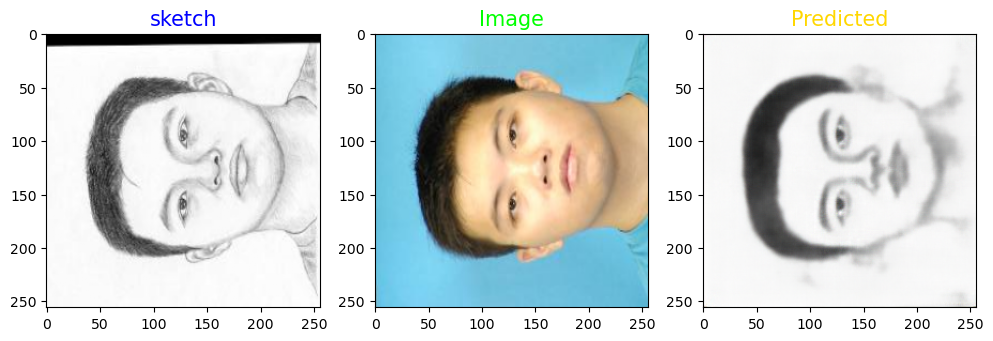

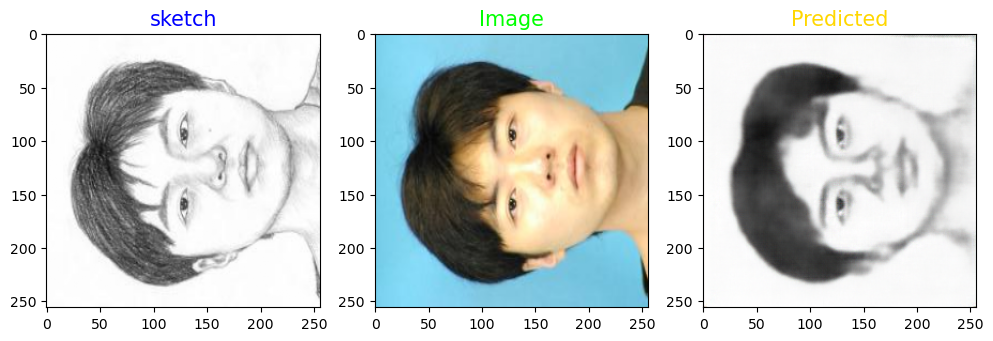

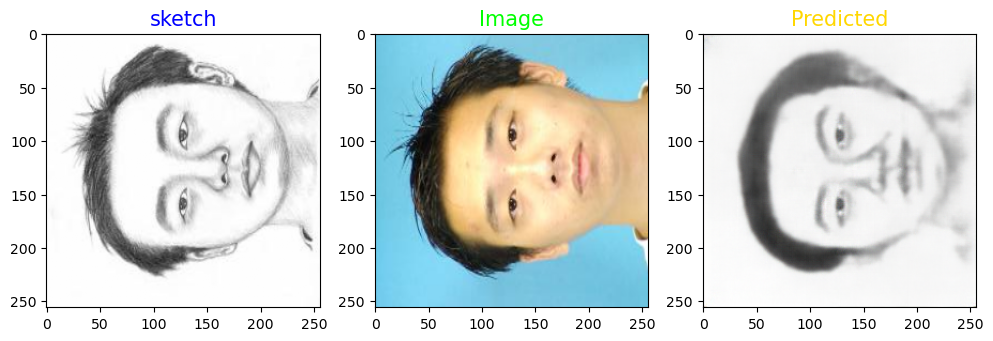

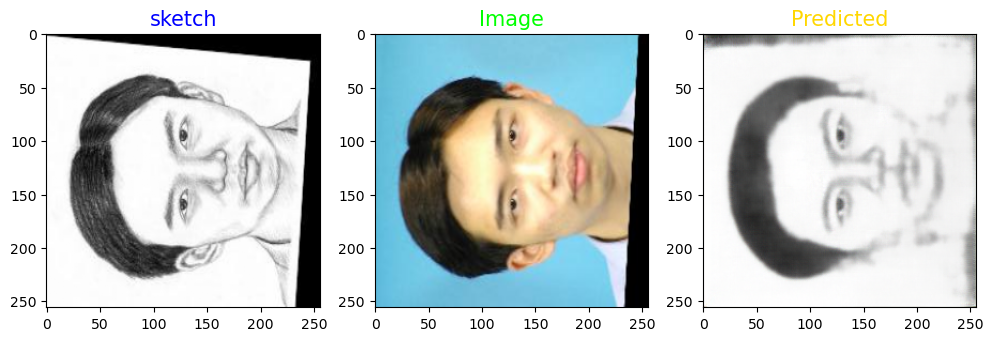

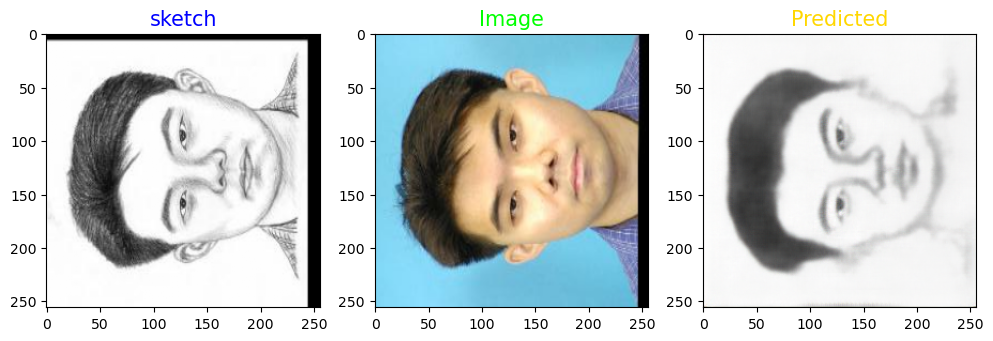

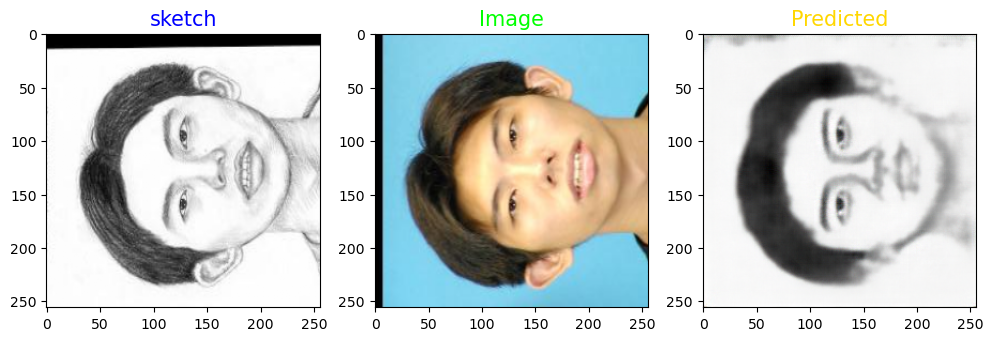

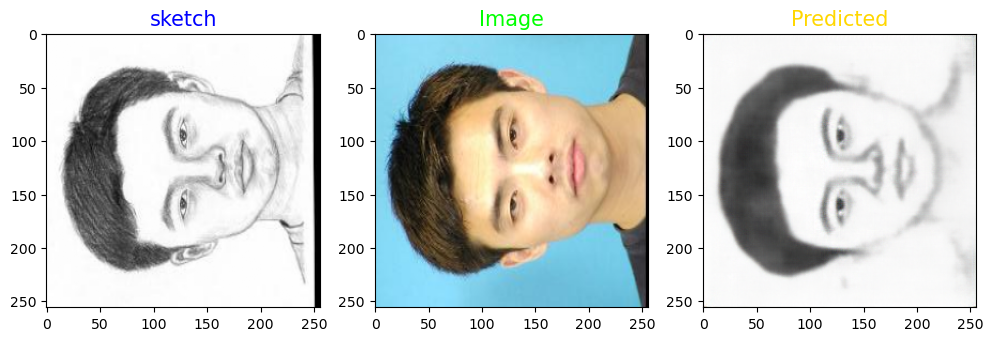

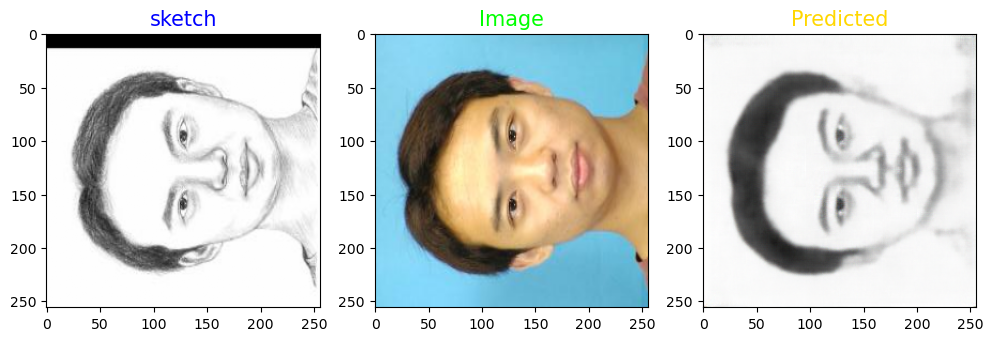

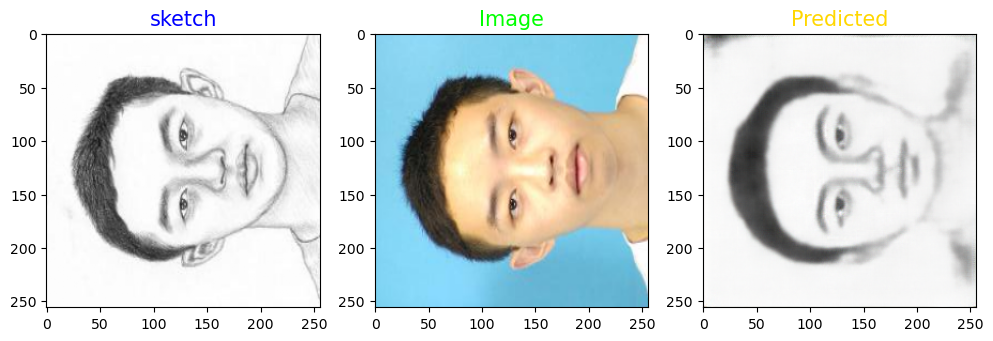

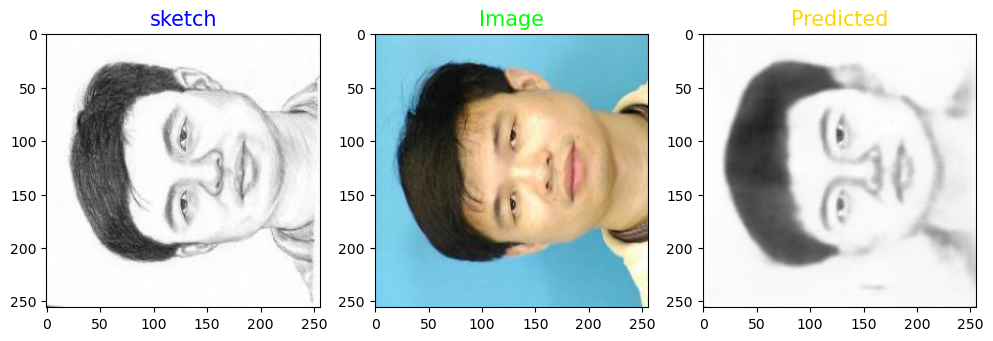

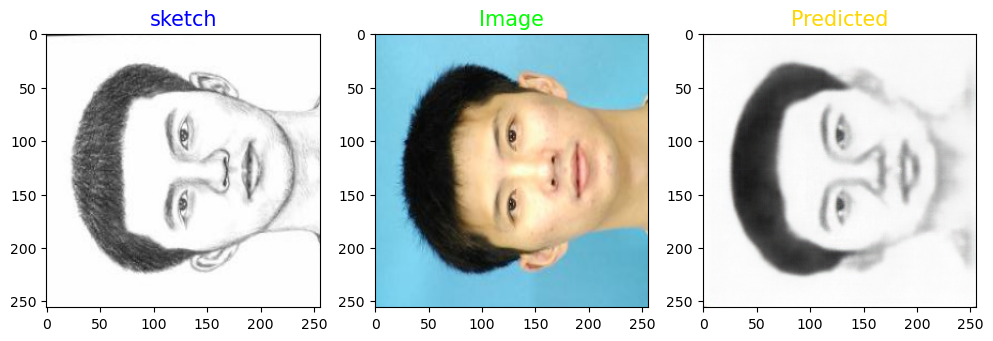

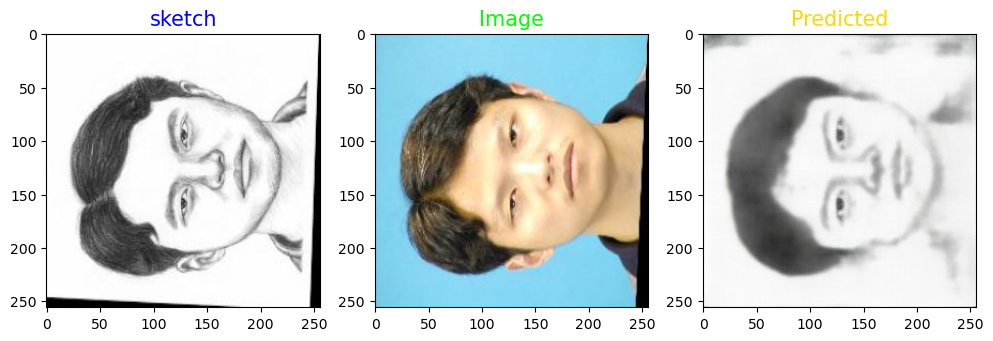

In [38]:
ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)